In [1]:
using Distributions
using StatsPlots
using SymPy
using Memoization
using StatsBase: ecdf

In [2]:
# 帰無仮説下での最尤法で得られる予測分布の期待値

function expectval(a, b, c, d)
    N = a + b + c + d
    A = (a + b)*(a + c)/N
    B = (a + b)*(b + d)/N
    C = (c + d)*(a + c)/N
    D = (c + d)*(b + d)/N
    A, B, C, D
end

@vars a b c d
expectval(a, b, c, d) |> collect

4-element Vector{Sym}:
 (a + b)*(a + c)/(a + b + c + d)
 (a + b)*(b + d)/(a + b + c + d)
 (a + c)*(c + d)/(a + b + c + d)
 (b + d)*(c + d)/(a + b + c + d)

In [3]:
# ピアソンのχ²統計量

safediv(x, y) = iszero(x) ? x : x/y

function chisqstat(a, b, c, d)
    A, B, C, D = expectval(a, b, c, d)
    safediv((a - A)^2, A) + safediv((b - B)^2, B) + safediv((c - C)^2, C) + safediv((d - D)^2, D)
end

@vars a b c d
chisqstat(a, b, c, d) |> factor

             2                 
  (a*d - b*c) *(a + b + c + d) 
-------------------------------
(a + b)*(a + c)*(b + d)*(c + d)

In [4]:
# ピアソンのχ²統計量の実装し直し

@memoize function chisqstat(a, b, c, d)
    safediv((a*d - b*c)^2 * (a + b + c + d), (a + b)*(c + d)*(a + c)*(b + d))
end
chisqstat(A) = chisqstat(A...)

@vars a b c d
chisqstat(a, b, c, d)

             2                 
  (a*d - b*c) *(a + b + c + d) 
-------------------------------
(a + b)*(a + c)*(b + d)*(c + d)

In [5]:
# 対数尤度比のG統計量

xlogy(x, y) = iszero(x) ? x : x*log(y)

@memoize function gstat(a, b, c, d)
    A, B, C, D = expectval(a, b, c, d)
    2(
        xlogy(a, a) - xlogy(a, A) +
        xlogy(b, b) - xlogy(b, B) +
        xlogy(c, c) - xlogy(c, C) +
        xlogy(d, d) - xlogy(d, D)
    )
end
gstat(A) = gstat(A...)

@vars a b c d
gstat(a, b, c, d)

                    /(a + b)*(a + c)\                       /(a + b)*(b + d)\ 
2*a*log(a) - 2*a*log|---------------| + 2*b*log(b) - 2*b*log|---------------| 
                    \ a + b + c + d /                       \ a + b + c + d / 

                      /(a + c)*(c + d)\                       /(b + d)*(c + d)
+ 2*c*log(c) - 2*c*log|---------------| + 2*d*log(d) - 2*d*log|---------------
                      \ a + b + c + d /                       \ a + b + c + d 

\
|
/

In [6]:
# multを独立性の帰無仮説を満たす四項分布とする

n = 100
p = 0.3
q = 0.4

mult = Multinomial(n, vec([p, 1-p]*[q, 1-q]'))

Multinomial{Float64, Vector{Float64}}(n=100, p=[0.12, 0.27999999999999997, 0.18, 0.42])

In [7]:
# 上で与えた分布multに従う乱数を沢山生成する。

L = 10^5
X = [rand(mult) for _ in 1:L]
first(X, 5) # 沢山生成した乱数のうち最初の5つ

5-element Vector{Vector{Int64}}:
 [11, 26, 14, 49]
 [11, 30, 10, 49]
 [16, 22, 20, 42]
 [10, 34, 19, 37]
 [11, 33, 18, 38]

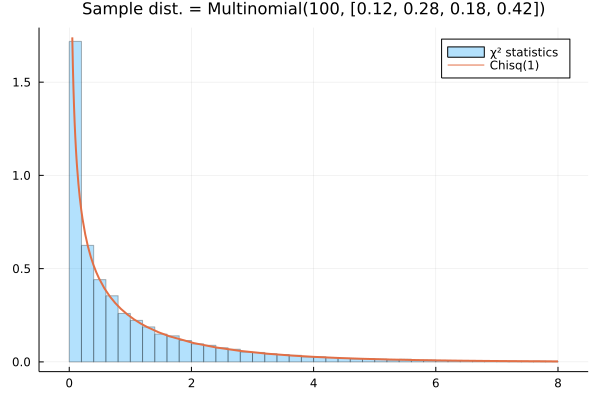

In [8]:
# ピアソンのχ²統計量の分布

chisqstatX = chisqstat.(X)
histogram(chisqstatX; norm=true, alpha=0.3, bin=0:0.2:8, label="χ² statistics")
plot!(Chisq(1), 0.05, 8; label="Chisq(1)", lw=2)
title!("Sample dist. = Multinomial($(ntrials(mult)), $(round.(probs(mult); digits=3)))"; titlefontsize=11)

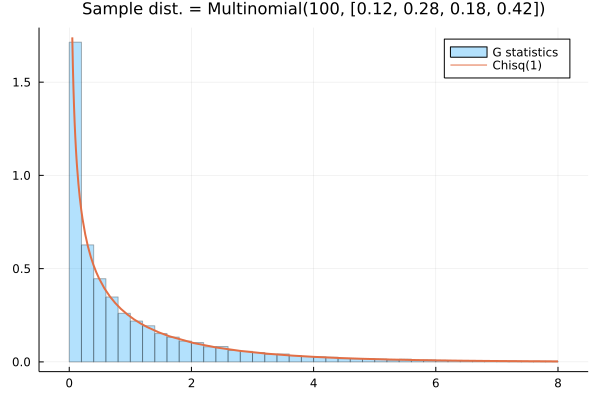

In [9]:
# 対数尤度比のG統計量の分布

gstatX = gstat.(X)
histogram(gstatX; norm=true, alpha=0.3, bin=0:0.2:8, label="G statistics")
plot!(Chisq(1), 0.05, 8; label="Chisq(1)", lw=2)
title!("Sample dist. = Multinomial($(ntrials(mult)), $(round.(probs(mult); digits=3)))"; titlefontsize=11)

In [10]:
# 自由度1のχ²分布でのP値

pvaluechisq1(x) = ccdf(Chisq(1), x)

pvaluechisq1 (generic function with 1 method)

In [11]:
# Fisher検定のP値

x ⪅ y = x < y || x ≈ y

@memoize function pvaluefisher(a, b, c, d)
    (a + b == 0 ||c + d == 0 || a + c == 0 || b + d == 0) && return 1.0
    hg = Hypergeometric(a + b, c + d, a + c) # 超幾何分布
    sum(pdf(hg, k) for k in support(hg) if pdf(hg, k) ⪅ pdf(hg, a))
end
pvaluefisher(A) = pvaluefisher(A...)

pvaluefisher (generic function with 2 methods)

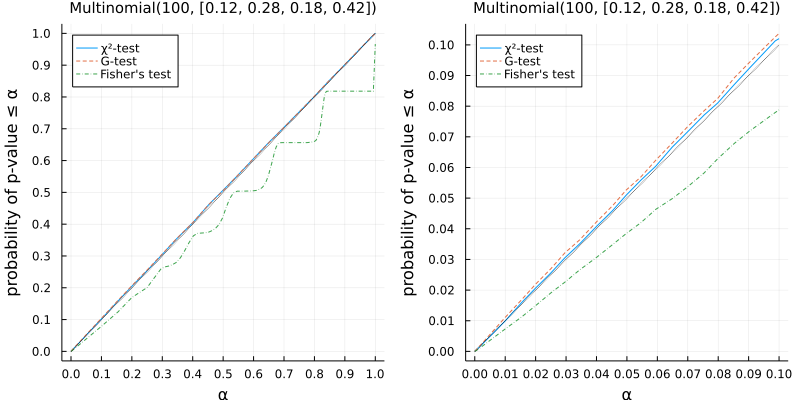

In [12]:
# 上の場合でのP値の経験累積分布函数(ecdf)のプロット
# 45度線に近い方がよい。

t = "Multinomial($(ntrials(mult)), $(round.(probs(mult); digits=3)))"

pvalchisqstat = pvaluechisq1.(chisqstatX)
pvalgstat = pvaluechisq1.(gstatX)
pvalfisher = pvaluefisher.(X)

ecdf_pvalchisqstat(x) = ecdf(pvalchisqstat)(x)
ecdf_pvalgstat(x) = ecdf(pvalgstat)(x)
ecdf_pvalfisher(x) = ecdf(pvalfisher)(x)

P = plot(; legend=:topleft)
plot!(ecdf_pvalchisqstat, 0.0, 1.0; label="χ²-test")
plot!(ecdf_pvalgstat, 0.0, 1.0; label="G-test", ls=:dash)
plot!(ecdf_pvalfisher, 0.0, 1.0; label="Fisher's test", ls=:dashdot)
plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
plot!(; xlabel="α", ylabel="probability of p-value ≤ α")
title!(t; titlefontsize=10)

Q = plot(; legend=:topleft)
plot!(ecdf_pvalchisqstat, 0.0, 0.1; label="χ²-test")
plot!(ecdf_pvalgstat, 0.0, 0.1; label="G-test", ls=:dash)
plot!(ecdf_pvalfisher, 0.0, 0.1; label="Fisher's test", ls=:dashdot)
plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
plot!(; xtick=0:0.01:0.2, ytick=0:0.01:0.2)
plot!(; xlabel="α", ylabel="probability of p-value ≤ α")
title!(t; titlefontsize=10)

plot!(P, Q; size=(800, 400), leftmargin=3Plots.mm)

In [13]:
# multsmallを小さなサンプルサイズでの独立性の帰無仮説を満たす四項分布とする

n = 20
p = 0.3
q = 0.4

multsmall = Multinomial(n, vec([p, 1-p]*[q, 1-q]'))

Multinomial{Float64, Vector{Float64}}(n=20, p=[0.12, 0.27999999999999997, 0.18, 0.42])

In [14]:
# 上で与えた分布multsmallに従う乱数を沢山生成する。

L = 10^5
Y = [rand(multsmall) for _ in 1:L]
first(Y, 5) # 沢山生成した乱数のうち最初の5つ

5-element Vector{Vector{Int64}}:
 [2, 9, 1, 8]
 [3, 8, 2, 7]
 [2, 5, 4, 9]
 [4, 2, 4, 10]
 [1, 7, 6, 6]

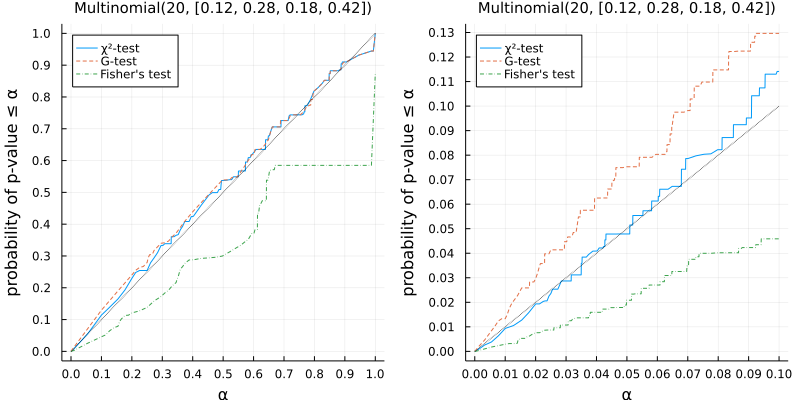

In [15]:
# 小サンプルの場合でのP値の経験累積分布函数(ecdf)のプロット
# 45度線に近い方がよい。

t = "Multinomial($(ntrials(multsmall)), $(round.(probs(multsmall); digits=3)))"

pvalchisqstat = pvaluechisq1.(chisqstat.(Y))
pvalgstat = pvaluechisq1.(gstat.(Y))
pvalfisher = pvaluefisher.(Y)

ecdf_pvalchisqstat(x) = ecdf(pvalchisqstat)(x)
ecdf_pvalgstat(x) = ecdf(pvalgstat)(x)
ecdf_pvalfisher(x) = ecdf(pvalfisher)(x)

P = plot(; legend=:topleft)
plot!(ecdf_pvalchisqstat, 0.0, 1.0; label="χ²-test")
plot!(ecdf_pvalgstat, 0.0, 1.0; label="G-test", ls=:dash)
plot!(ecdf_pvalfisher, 0.0, 1.0; label="Fisher's test", ls=:dashdot)
plot!([0, 1], [0, 1]; label="", ls=:dot, c=:black)
plot!(; xtick=0:0.1:1, ytick=0:0.1:1)
plot!(; xlabel="α", ylabel="probability of p-value ≤ α")
title!(t; titlefontsize=10)

Q = plot(; legend=:topleft)
plot!(ecdf_pvalchisqstat, 0.0, 0.1; label="χ²-test")
plot!(ecdf_pvalgstat, 0.0, 0.1; label="G-test", ls=:dash)
plot!(ecdf_pvalfisher, 0.0, 0.1; label="Fisher's test", ls=:dashdot)
plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
plot!(; xtick=0:0.01:0.2, ytick=0:0.01:0.2)
plot!(; xlabel="α", ylabel="probability of p-value ≤ α")
title!(t; titlefontsize=10)

plot!(P, Q; size=(800, 400), leftmargin=3Plots.mm)